In [78]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model
import seaborn as sns
from utils import drop_repeat,cal_cross_validated,generate_marker,BlurPooling1D
np.set_printoptions(suppress=True)
from keras.utils import CustomObjectScope
%matplotlib inline

In [79]:
def plot_scatter(df_crossed,pool_factor,x="accuracy",y="consis_b"):
    plt.title(str(pool_factor) + " Layer CNN",fontsize=20)
    for row in df_crossed[df_crossed.pool_factor==pool_factor].iterrows():
        marker = row[1]["marker"]
        label = row[1]["pool_type"]
        
        _x = row[1][x]
        _y = row[1][y]
        
        pool_factor = row[1]["pool_factor"]
        if pool_factor == 1:
            edge_color = "b"
        elif pool_factor == 2:
            edge_color = "r"
        elif pool_factor == 3:
            edge_color = "purple"
        c = 'w'
        if marker == "|":
            c = edge_color
        plt.scatter(x=_x,y=_y,marker=marker,c=c,edgecolors=edge_color,s=100,label=label)

In [80]:
def cal_blur_size(pool_type):
    if "maxblur" in pool_type:
        return int(pool_type[-1])
    if pool_type=="max":
        return 0
    if pool_type=="avg":
        return -1

## Read result dataframe (CNN)

In [91]:
result_roots = ["./Result_CNN_pool1/","./Result_CNN_pool2/","./Result_CNN_pool3/",
               "./Result_CNN_aug_pool1/","./Result_CNN_aug_pool2/","./Result_CNN_aug_pool3/"]

In [92]:
result_files = []
for result_root in result_roots:
    result_dirs = [os.path.join(result_root,i) for i in os.listdir(result_root) if "results" in i]
    for result_dir in result_dirs:
        result_file = os.path.join(result_dir,"new_rseult_2.csv")
        if os.path.exists(result_file):
            result_files.append(result_file)
result_files.sort()

In [93]:
dfs = []
for file in result_files:
    df = pd.read_csv(file)
    df = df.drop("Unnamed: 0",axis=1)
    pool_type = list(df["pool_type"])[0]
    if pool_type == "maxblur-":
        df["pool_type"] = ["avg" for i in range(len(df))]
        pool_type = "avg"
    df["with_augment"] = ["aug" in file for i in range(len(df))]
    df["marker"] = [generate_marker(pool_type) for i in range(len(df))]
    df["blur_size"] = [cal_blur_size(pool_type) for i in range(len(df))]
    dfs.append(df)
result_df = pd.concat(dfs)

In [94]:
result_df.to_csv("final_result.csv",header=True)

In [95]:
result_df_crossed = cal_cross_validated(result_df,cross=5)
result_df_crossed.to_csv("final_result_crossed.csv",header=True)

In [96]:
len(result_df_crossed) == 7*6

True

## Bubble plot

In [99]:
result_df_crossed[result_df_crossed.pool_factor==1]

,pool_factor,pool_type,marker,loss,accuracy,consis_b,consis_b_std,consis_ub,consis_n,consis_a,consis_a_s,robustness,with_augment
0,1,max,$M$,1.049271,0.908876,0.983427,0.019407,0.984589,0.967717,0.987592,0.999136,0.912728,True
1,1,avg,$A$,0.731480,0.937249,0.980399,0.018135,0.986580,0.962649,0.990979,0.998148,0.882716,True
2,1,maxblur-3,^,0.971300,0.919108,0.973950,0.027617,0.979517,0.949331,0.984997,0.998569,0.783951,True
3,1,maxblur-4,D,0.820239,0.924234,0.970100,0.025586,0.973017,0.956744,0.975896,0.983456,0.838654,True
4,1,maxblur-5,p,0.934157,0.891491,0.955689,0.043245,0.953658,0.957944,0.952779,0.953434,0.877980,True
5,1,maxblur-6,h,1.158380,0.917426,0.972497,0.021183,0.985626,0.963711,0.989612,0.981283,0.867813,True
6,1,maxblur-7,*,0.877625,0.902764,0.973932,0.022358,0.965464,0.957337,0.966792,0.990527,0.838654,True
21,1,max,$M$,0.713934,0.861072,0.804350,0.054495,0.723662,0.864006,0.697955,0.744695,0.816425,False
22,1,avg,$A$,0.742720,0.803283,0.799640,0.071211,0.746224,0.829273,0.730771,0.770006,0.735736,False
23,1,maxblur-3,^,0.647956,0.865392,0.849115,0.057784,0.778063,0.915121,0.752547,0.783109,0.774068,False


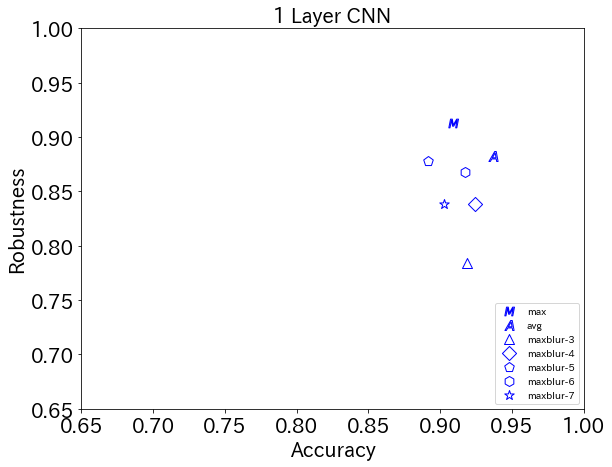

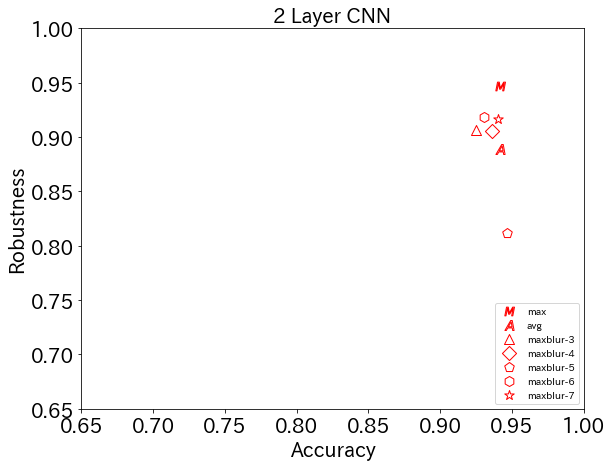

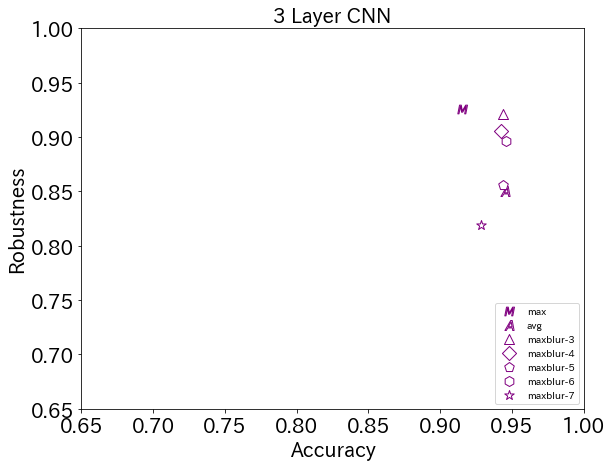

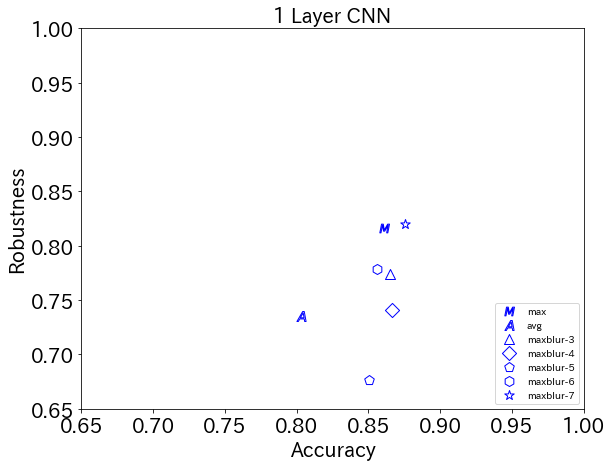

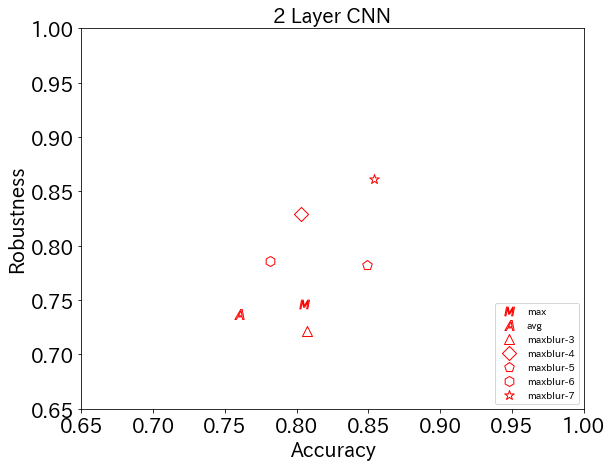

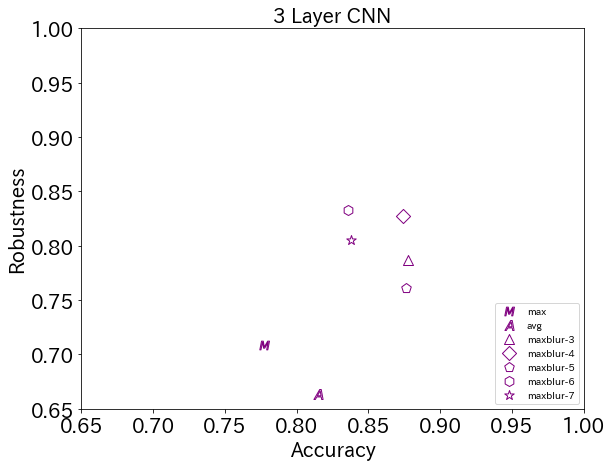

In [112]:
for aug in [True,False]:
    for pool_factor in [1,2,3]:
        if aug:
            suffix = "_w"
        else:
            suffix = "_wo"
        save_path = os.path.join("figs/result_acc-robust",str(pool_factor)+"CNN"+suffix+".png")
        
        plt.figure(figsize=(9,7))
        plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&
                                      (result_df_crossed.pool_type!="maxblur-2")&
                                       (result_df_crossed.with_augment==aug)],
                     pool_factor=pool_factor,x="accuracy",y="robustness")

        plt.xlabel("Accuracy",fontsize=20)
        plt.ylabel("Robustness",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlim(0.65,1.0)
        plt.ylim(0.65,1.0)
        plt.legend(loc="lower right")
        plt.savefig(save_path)

In [113]:
best_dict = {
    1:"maxblur-7",
    2:"maxblur-7",
    3:"maxblur-4"
}

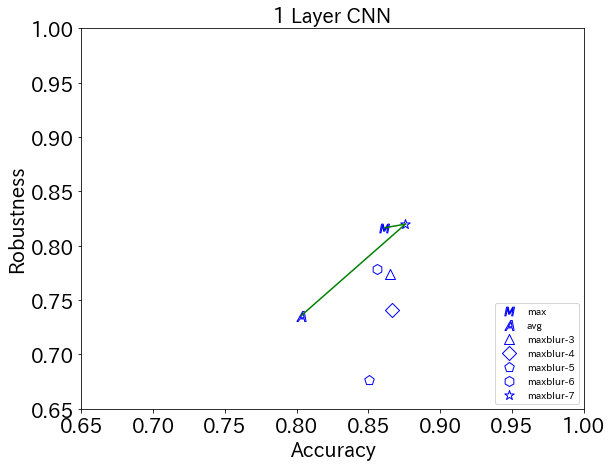

In [120]:
pool_factor = 1
plt.figure(figsize=(9,7))
best_method = best_dict[pool_factor]
plot_scatter(result_df_crossed[(result_df_crossed.pool_type!="maxblur-1")&
                          (result_df_crossed.pool_type!="maxblur-2")&
                           (result_df_crossed.with_augment==False)],
         pool_factor=pool_factor,x="accuracy",y="robustness")
base_lines = ["max","avg"]
x_s = []
y_s = [] 
for base_line in base_lines:
    start_x = float(result_df_crossed[(result_df_crossed.pool_factor==pool_factor)&(result_df_crossed.with_augment==False)&
                               (result_df_crossed.pool_type==base_line)]["accuracy"])
    start_y = float(result_df_crossed[(result_df_crossed.pool_factor==pool_factor)&(result_df_crossed.with_augment==False)&
                               (result_df_crossed.pool_type==base_line)]["robustness"])
    end_x = float(result_df_crossed[(result_df_crossed.pool_factor==pool_factor)&(result_df_crossed.with_augment==False)&
                               (result_df_crossed.pool_type==best_method)]["accuracy"])
    end_y = float(result_df_crossed[(result_df_crossed.pool_factor==pool_factor)&(result_df_crossed.with_augment==False)&
                               (result_df_crossed.pool_type==best_method)]["robustness"])
    plt.plot([start_x,end_x],[start_y,end_y],c="g")

plt.xlabel("Accuracy",fontsize=20)
plt.ylabel("Robustness",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.65,1.00)
plt.ylim(0.65,1.00)
plt.legend(loc="lower right")
save_path = os.path.join("figs/",str(pool_factor)+"CNN"+"_wo_improvement.png")
plt.savefig(save_path)

## Plot Blur Filter

In [ ]:
def Get_BlurFilter(filt_size):
    if(filt_size==1):
        return np.array([1.,])
    elif(filt_size==2):
        return np.array([1., 1.])
    elif(filt_size==3):
        return np.array([1., 2., 1.])
    elif(filt_size==4):    
        return np.array([1., 3., 3., 1.])
    elif(filt_size==5):    
        return np.array([1., 4., 6., 4., 1.])
    elif(filt_size==6):    
        return np.array([1., 5., 10., 10., 5., 1.])
    elif(filt_size==7):    
        return np.array([1., 6., 15., 20., 15., 6., 1.])

In [ ]:
blur_size = 5
for blur_size in [i+2 for i in range(6)]:
    print(blur_size)
    plt.figure(figsize=(1,5))
    _filter = np.expand_dims(Get_BlurFilter(blur_size),axis=0)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(_filter,cmap="Greys")

In [ ]:
import matplotlib
plt.figure(figsize=(1,1))
cmap = matplotlib.cm.Greys
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.imshow(np.expand_dims(np.array([.5,.5,.5,.5]),axis=0),cmap=cmap,norm=norm)
#plt.colorbar()
plt.xticks([])
plt.yticks([])